# Modeling and Evaluation

## Objectives
Predict medical insurance charges using customer profile information.

## Inputs
- Processed customer dataset with feature engineering.

## Outputs
- Trained ML regression model.
- Feature importance ranking.

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/medical-insurance-prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/medical-insurance-prediction'

---

# Load Engineered Dataset

In [4]:
import pandas as pd
df_path = 'outputs/datasets/cleaned/insurance_cleaned.csv'
df = pd.read_csv(df_path)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Remove warning messages

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['charges'], axis=1),
                                                    df['charges'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                   )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1070, 6) (1070,) (268, 6) (268,)


# ML Pipeline for Data Cleaning and Feature Engineering

Based on the last notebook, we will create our ML pipeline for data cleaning and feature engineering.

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

def PipelineDataCleaningAndFeatureEngineering():
    categorical_vars = ['sex', 'smoker', 'region']
    numerical_vars = ['age', 'bmi']

    pipeline = Pipeline([
        ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
                                           variables=categorical_vars)),
        ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(),
                                             variables=numerical_vars))
    ])
    
    return pipeline

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['sex', 'smoker', 'region'])),
                ('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['age', 'bmi']))])

**Fit Pipeline**

In [8]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()

X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1070, 6) (1070,) (268, 6) (268,)


Check if the pipeline does the feature engineering correctly.

In [40]:
X_test

,age,sex,bmi,children,smoker,region
578,0.916684,0,-0.085396,1,1,0
610,0.561612,1,-0.219622,1,1,1
569,0.632626,0,1.590813,2,0,3
1034,1.555814,0,1.237459,0,1,3
198,0.845669,1,-2.050273,0,1,3
...,...,...,...,...,...,...
1084,1.626829,1,-0.037689,2,1,3
726,0.135525,0,-0.375681,1,1,3
1132,1.271756,0,1.544723,0,1,2
725,-0.645634,1,1.345810,3,0,1


In [9]:
X_train

,age,sex,bmi,children,smoker,region
621,-0.148533,0,0.545305,4,0,0
194,-1.497808,0,0.598672,0,1,1
240,-1.142736,1,0.960921,2,0,2
1168,-0.503605,0,0.723195,2,1,0
1192,1.342771,1,0.269575,1,1,2
...,...,...,...,...,...,...
763,-0.858678,0,-0.759761,0,1,2
835,0.206539,0,0.847718,2,1,1
1216,0.064510,0,-0.913394,0,1,1
559,-1.426793,0,0.776562,0,1,3


# ML Pipeline for Modelling and Hyperparameter Optimisation

- **SmartCorrelation:** removes features with high correlation to avoid multicollinearity.
- **model:** the ML algorithm

In [10]:

# Feat Selection
from feature_engine.selection import SmartCorrelatedSelection

def PipelineClf(model):
    return Pipeline([
        ('correlation_filter', SmartCorrelatedSelection(
            method='pearson',
            threshold=0.8,
            selection_method='variance')),
        ('model', model)
    ])

---

## Hyperparameter Optimisation

**Hyperparameter Optimisation**

This is the process of tuning the hyperparameters of a machine learning model to improve its performance. It involves searching for the best combination of hyperparameters that yield the highest performance on a validation set.

In [11]:
from sklearn.model_selection import GridSearchCV
import numpy as np

class HyperparameterOptimizationSearch:
    """
    Custom class provided by CI
    """
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Grid Search CV - Sklearn

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__bootstrap': [True]
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.2],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    "XGBRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.2],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    },
}

**Run Grid Search CV**

In [14]:
# Grid Search
search = HyperparameterOptimizationSearch(
    models=models_quick_search,
    params=params_quick_search
)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/cistudent/.local/lib/pyt

Check the results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                     estimator min_score mean_score max_score std_score  \
118               XGBRegressor  0.802337   0.843992  0.877252  0.026326   
117               XGBRegressor  0.802048   0.842979  0.873779  0.025076   
102               XGBRegressor   0.81213   0.842338  0.877135   0.02246   
101               XGBRegressor  0.813438    0.84203  0.875642  0.021446   
38   GradientBoostingRegressor  0.797585   0.841066  0.873368   0.02679   
..                         ...       ...        ...       ...       ...   
10       DecisionTreeRegressor  0.651559   0.686071  0.755997  0.037609   
2        DecisionTreeRegressor  0.651559   0.686071  0.755997  0.037609   
5        DecisionTreeRegressor  0.646317    0.68421  0.742718  0.034836   
1        DecisionTreeRegressor  0.635595   0.668553  0.708162  0.027522   
9        DecisionTreeRegressor  0.635595   0.666445  0.708162  0.028097   

    model__max_depth model__min_samples_leaf model__min_samples_split  \
118                3      

**Evaluate the Best Model**

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

best_model = grid_search_summary.iloc[0]['estimator']
print("Best Model:", best_model)
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Best Model: XGBRegressor
Model Evaluation 

* Train Set
R2 Score: 0.891
Mean Absolute Error: 2148.08
Mean Squared Error: 15585545.415
Root Mean Squared Error: 3947.853


* Test Set
R2 Score: 0.898
Mean Absolute Error: 2448.13
Mean Squared Error: 16296948.669
Root Mean Squared Error: 4036.948




Parameters for best model

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__colsample_bytree': 1.0,
 'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100,
 'model__subsample': 1.0}

The best clf pipeline

In [18]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('correlation_filter',
                 SmartCorrelatedSelection(selection_method='variance')),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [19]:
pipeline_clf.steps

[('correlation_filter', SmartCorrelatedSelection(selection_method='variance')),
 ('model',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=0, ...))]

The XGBRegressor model has demonstrated strong predictive performance on both the training and test datasets.
- **R² Score: 0.891:** The model explains 89.1% of the variance in insurance costs on the training data, indicating a strong fit. 
- Low gap between train/test scores — not overfitting
- Low error metrics — strong predictions
- Stable RMSE on train/test — very balanced model

XGBRegressor is an optimal choice for this regression task based on both accuracy and stability.With these strong evaluation scores, you are already in excellent shape and an extensive search is not going to be necessary.

---

## Assess feature importance

In [20]:
# Get transformed feature matrix
X_transformed = pipeline_clf[:-1].transform(X_train)

# Get feature mask from correlation filter
model_selector = pipeline_clf.named_steps['correlation_filter']
selected_mask = model_selector.get_support()

# Apply mask to original feature names
all_features = X_train.columns
selected_features = all_features[selected_mask]

# Get feature importances
model = pipeline_clf.named_steps['model']
importances = model.feature_importances_

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


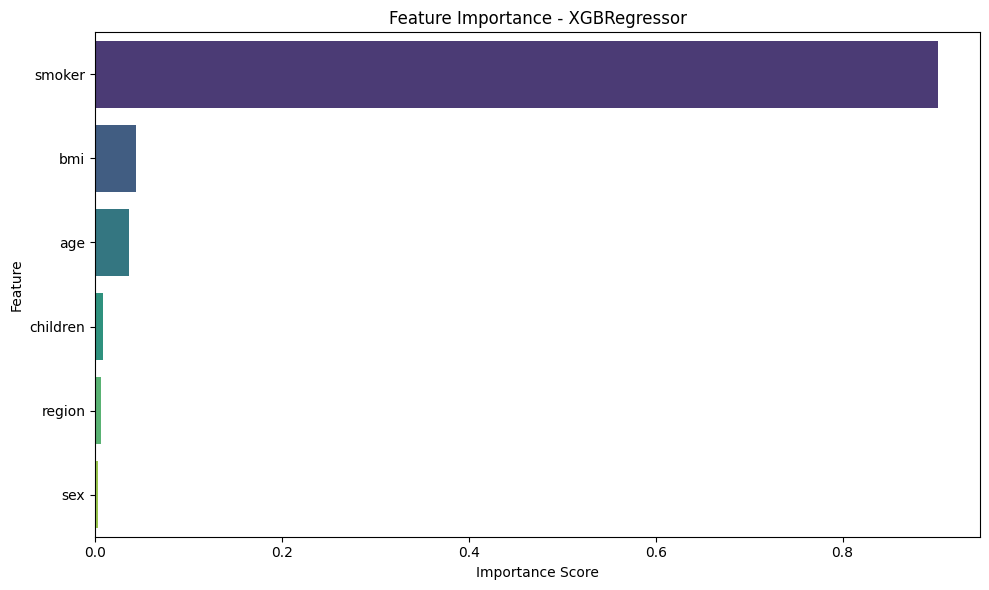

    Feature  Importance
4    smoker    0.902035
2       bmi    0.044251
0       age    0.036724
3  children    0.008019
5    region    0.006020
1       sex    0.002950


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f'Feature Importance - {model.__class__.__name__}')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
print(importance_df)

---

## Evaluate Pipeline on Train and Test Sets

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


In [23]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)


Model Evaluation 

* Train Set
R2 Score: 0.891
Mean Absolute Error: 2148.08
Mean Squared Error: 15585545.415
Root Mean Squared Error: 3947.853


* Test Set
R2 Score: 0.898
Mean Absolute Error: 2448.13
Mean Squared Error: 16296948.669
Root Mean Squared Error: 4036.948




We used R2 Score, MAE and RMSE to evaluate the model performance, since Confusion Matrix and Accuracy are not suitable for regression problems.

**Evaluation Conclusion**

The XGBRegressor demonstrates strong predictive performance and generalization capability in estimating medical insurance costs. Its test set R² score of 0.891 indicates that the model explains approximately 89% of the variance in insurance charges for unseen data, which is excellent for a real-world regression task. Low and consistent error across training and test sets shows good generalization with minimal overfitting. Feature importance analysis confirms which variables most influence the cost, helping the business better understand risk drivers.


# Push files to Repo

We will generate the following file
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [24]:
import joblib
import os

version = "v1"
file_path = f"outputs/ml_pipelines/{version}"

try:
    os.makedirs(file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipelines/v1'


## Train Set

In [25]:
print(X_train.shape)
X_train.head()

(1070, 6)


,age,sex,bmi,children,smoker,region
621,-0.148533,0,0.545305,4,0,0
194,-1.497808,0,0.598672,0,1,1
240,-1.142736,1,0.960921,2,0,2
1168,-0.503605,0,0.723195,2,1,0
1192,1.342771,1,0.269575,1,1,2


In [26]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [27]:
y_train

621     40182.24600
194      1137.46970
240     38511.62830
1168     4670.64000
1192    13019.16105
           ...     
763      3070.80870
835      7160.33030
1216     5415.66120
559      1646.42970
684      4766.02200
Name: charges, Length: 1070, dtype: float64

In [28]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [29]:
print(X_test.shape)
X_test.head()

(268, 6)


,age,sex,bmi,children,smoker,region
578,0.916684,0,-0.085396,1,1,0
610,0.561612,1,-0.219622,1,1,1
569,0.632626,0,1.590813,2,0,3
1034,1.555814,0,1.237459,0,1,3
198,0.845669,1,-2.050273,0,1,3


In [30]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [31]:
y_test

578      9724.53000
610      8547.69130
569     45702.02235
1034    12950.07120
198      9644.25250
           ...     
1084    15019.76005
726      6664.68595
1132    20709.02034
725     40932.42950
963      9500.57305
Name: charges, Length: 268, dtype: float64

In [32]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Feature Engineering and Modelling

Pipeline responsible for Feature Scaling, and Model

In [33]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).ravel()

In [34]:
full_pipeline = pipeline_clf.fit(X_train, y_train_transformed)
full_pipeline

Pipeline(steps=[('correlation_filter',
                 SmartCorrelatedSelection(selection_method='variance')),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [35]:
joblib.dump(value=full_pipeline ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipelines/v1/clf_pipeline_model.pkl']

In [36]:
joblib.dump(pt, f"{file_path}/power_transformer.pkl")

['outputs/ml_pipelines/v1/power_transformer.pkl']

## Feature Importance Plot and CSV

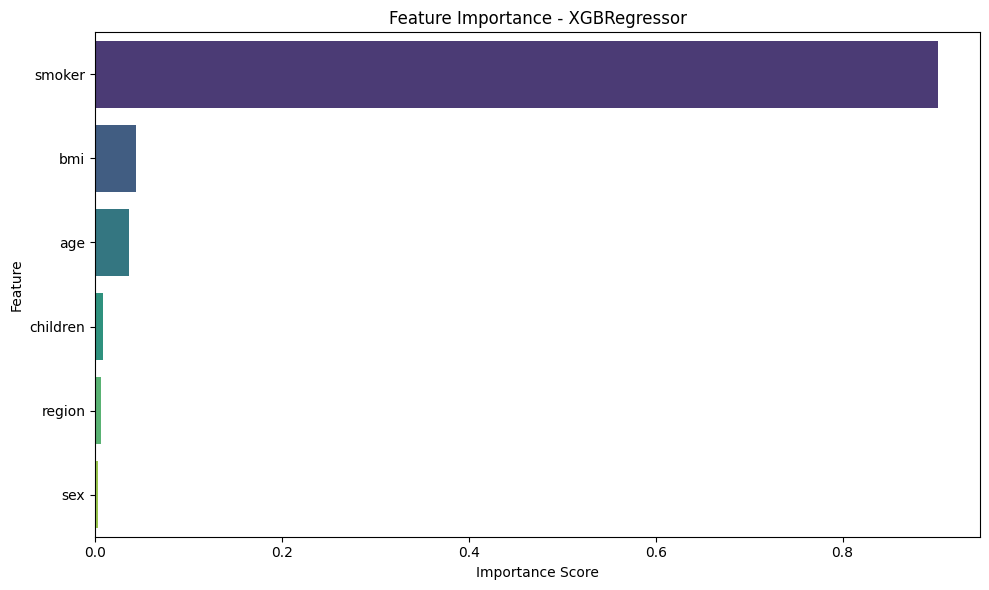

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - XGBRegressor')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# Save to PNG
plt.savefig(f"{file_path}/feature_importance_xgb.png", dpi=300)
plt.show()

In [38]:
importance_df.to_csv(f"{file_path}/feature_importance_xgb.csv", index=False)

---

In [39]:
idx = 110  # any index
X_sample = X_train.iloc[[idx]]
y_true = y_train.iloc[idx]
y_true_transformed = y_train_transformed[idx]

print(f"Sample features:\n{X_sample}\n")
y_pred_transformed = pipeline_clf.predict(X_sample)[0]
y_pred = pt.inverse_transform([[y_pred_transformed]])[0][0]
y_true_original = pt.inverse_transform([[y_true_transformed]])[0][0]
print(f"True value:     {y_true_original:,.2f}")
print(f"Predicted value:{y_pred:,.2f}")

Sample features:
          age  sex       bmi  children  smoker  region
271  0.774655    0  0.561477         2       0       0

True value:     42,856.84
Predicted value:40,659.11
